In [3]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns

#Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.utils import class_weight

#Tensorflow
import tensorflow as tf
import tensorflow.keras.layers as lyrs
from tensorflow.keras.applications import MobileNetV2
from keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_hub as hub
from tensorflow.keras.optimizers.legacy import Adam


In [5]:
root="/Users/futuregadgetlab/Downloads/ai_art_classification/"
IMG_SIZE=512

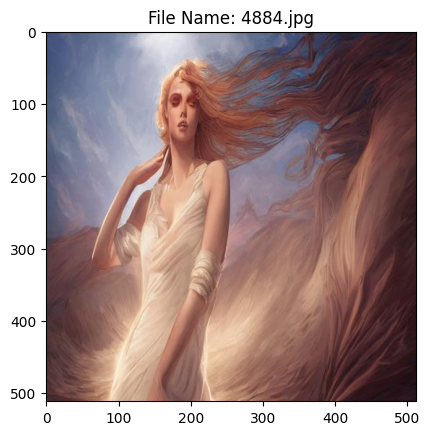

In [14]:



def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(precision_score(y_true, y_pred, average='weighted')))
    
def view_random_image(root_path,folder,class_folder):
    path=root_path+'/'+folder+'/'+class_folder
    rand=random.choice(os.listdir(path))
    random_image=mpimg.imread(path+'/'+rand)
    plt.imshow(random_image)
    plt.title("File Name: " + rand)
    
def pre_process_image(path, image_shape=512, channels=3, norm_factor=255.):
    '''Pre-Processing the Image before sending it to the model'''
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=channels)
    img = tf.image.resize(img, size = (image_shape, image_shape))
    img = tf.expand_dims(img, axis=0)
    img = img/norm_factor
    return img

def custom_rounder(x):
    values=tf.math.round(x).numpy()
    values=np.argmax(values, axis=1)
    if(values>0.5):
        return 1
    else:
        return 0

def random_tester(root_path, classes, model, class_type="binary"):
    '''Random Class Folder Selection'''
    path=root_path
    class_folder=random.choice(os.listdir(path))
    
    '''Random File Selection'''
    folder_path=path+'/'+class_folder+'/'
    rand=random.choice(os.listdir(folder_path))
    file_path=folder_path+'/'+rand
    random_image=mpimg.imread(file_path)
    
    '''Prediction'''
    predicted_value=model.predict(pre_process_image(file_path)) 
    if(class_type=="binary"):
        predicted_label=classes[custom_rounder(predicted_value)]
    else:
        index=tf.math.round(predicted_value).numpy()
        index=np.argmax(index)
        predicted_label=classes[index]
        
    '''Visualize'''
    plt.figure(figsize=(4, 4))
    plt.imshow(random_image)
    if(predicted_label==class_folder):
        clr="green"
    else:
        clr="red"
    plt.title("Prediction:" + predicted_label +"\n" +"True class: "+ class_folder,color=clr)
    plt.show()
    
def loss_curve_plot(df):
    """ Dataframe (df) is history of the fit of the NN model
    The df consists of train and validation fit data
    """
    history = df.history
    val_accuracy = history["val_accuracy"]
    val_loss = history["val_loss"]
    train_accuracy = history["accuracy"]
    train_loss = history["loss"]
    
    """Accuracy Plot"""
    plt.plot(train_accuracy, label="Train Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
    
    """Loss Plot"""
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title("Loss Curves")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
def confusion_matrix_plot(y_true, y_pred, figsize=(30,30)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)
    sns.heatmap(cm, annot=True, cmap="crest")

view_random_image(root,"train","AI_GENERATED")


In [8]:
train_datagen=image_dataset_from_directory(
    root+"/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    validation_split=0.2,
    label_mode='categorical',
    subset="training",
    shuffle=True,
    seed=55
)

val_datagen=image_dataset_from_directory(
    root+"/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    validation_split=0.2,
    label_mode='categorical',
    subset="validation",
    shuffle=False,
    seed=55
)

Found 18618 files belonging to 2 classes.
Using 14895 files for training.
Found 18618 files belonging to 2 classes.
Using 3723 files for validation.


In [15]:
model_base = MobileNetV2(
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    include_top=False,
)
model_base.trainable = False

inputs=tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x=model_base(inputs)
x = pre_process_image(root+"/train", IMG_SIZE,3,255)
x=lyrs.GlobalAveragePooling2D()(x)
x= lyrs.BatchNormalization()(x)
x= lyrs.Dropout(0.5)(x)
outputs=lyrs.Dense(2, activation="softmax")(x)

2023-07-29 17:06:17.707254: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at whole_file_read_ops.cc:116 : FAILED_PRECONDITION: /Users/futuregadgetlab/Downloads/ai_art_classification/train; Is a directory


FailedPreconditionError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /Users/futuregadgetlab/Downloads/ai_art_classification/train; Is a directory [Op:ReadFile]

In [ ]:

model.summary()

In [ ]:
checkpointer = ModelCheckpoint('ai_art_classification.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer='adam'(lr=1e-3, decay=1e-3), metrics=["accuracy"])
model_history=model.fit(x=train_datagen, 
         steps_per_epoch=32,
         validation_data=val_datagen,
         epochs=20,
         callbacks=[checkpointer, early_stopping])

In [ ]:
labels=val_datagen.classes
model=tf.keras.models.load_model("/kaggle/working/ai_art_classification.hdf5")
y_pred=model.predict(val_datagen)
prediction=tf.math.round(y_pred).numpy()
prediction=prediction.argmax(axis=1)

supervised_metrics(labels, prediction)
confusion_matrix_plot(labels, prediction, figsize=(5,5))

for i in range(0,11):
    random_tester(root+"/train", os.listdir(root+"/train"), model)